# Compute the style of an image

Based on the paper by Gatis et al. 2016 ([ref](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf)).
other refs:
https://arxiv.org/abs/1606.01286
https://arxiv.org/abs/1603.08155

Improvment:

- compute gram only on inner part of the image (e.g. 3:-3), that might fix some issues with the stability of jittering
- randomly cancel or *.1 some features (i.e. row and column of gram matrix) when computing the styloe loss

In [2]:
# Imports
import torch
import torchvision
from torch import nn
import skimage
from skimage import transform
from skimage import io
# from im_func import show_image, timer
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import torch.nn.functional as F
import torchvision.transforms.functional as TF

# Get images

(-0.5, 499.5, 649.5, -0.5)

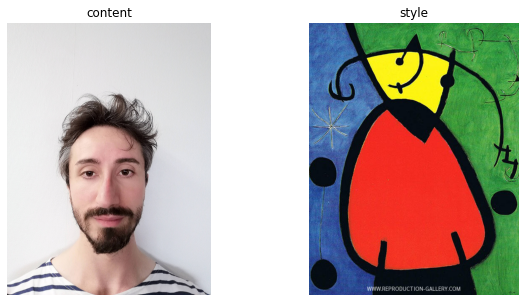

In [3]:
# content_im = skimage.data.coffee()
content_im = skimage.io.imread("https://github.com/abauville/Neural_style_transfer/blob/main/Data/IMG_20210617_094559.jpg?raw=true")
# content_im = skimage.io.imread("https://github.com/abauville/Neural_style_transfer/blob/main/Data/Cecile2.jpg?raw=true")
# content_im = skimage.io.imread("https://github.com/abauville/Neural_style_transfer/blob/main/Data/hokusai_wave.png?raw=true")
style_im = skimage.io.imread("https://github.com/abauville/Neural_style_transfer/blob/main/Data/miro_breakofday.jpeg?raw=true")


# style_im = skimage.io.imread("https://github.com/jcjohnson/fast-neural-style/blob/master/images/styles/composition_vii.jpg?raw=True")




fig, ax = plt.subplots(1,2,figsize=[10,5])
plt.sca(ax[0])
_ = plt.imshow(content_im); plt.title("content"); plt.axis("off")
plt.sca(ax[1])
_ = plt.imshow(style_im); plt.title("style"); plt.axis("off")

# Pre/post processing of image

Normalization, resizing etc... to correspond to the input format of images trained by t

In [4]:
# From D2L
im_shape = (150, 225)
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)
    ])
    return transforms(img).unsqueeze(0)

def postprocess(img):
    img = img[0].to(rgb_std.device)
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

# Get a pretrained model

In [5]:
pretrained_net = torchvision.models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [6]:
pretrained_net.features[0]

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

# Defined the image generator network and a function to make a partial pass through the network

In [7]:
class ImageGenerator(nn.Module):
    def __init__(self,image):
        super(ImageGenerator,self).__init__()
        # self.im = nn.Parameter(torch.rand(1, 3, *shape))
        self.im = nn.Parameter(torch.rand(image.shape)+image)
        self.transform = torchvision.transforms.RandomAffine(0, translate=(1./im_shape[1],1./im_shape[0]))
        # self.transform = torchvision.transforms.RandomAffine((-0.001,0.001), translate=(1./im_shape[1],1./im_shape[0]), interpolation=torchvision.transforms.InterpolationMode.BILINEAR)
        self.jit_i = 0.0
        self.jit_j = 0.0
        self.angle=0.0
    def jitter(self):
        with torch.no_grad():
            self.im.data = torchvision.transforms.functional.affine(self.im.data, angle=-self.angle, translate=(-self.jit_i/im_shape[1], -self.jit_j/im_shape[0]), scale=1., shear=[0.0,0.0],interpolation=torchvision.transforms.InterpolationMode.BILINEAR)
            jit_max = 3
            temp = np.random.standard_normal(2)*.5
            self.jit_i += temp[0]
            self.jit_j += temp[1]

            angle_max = 2.0
            self.angle += np.random.standard_normal(1)[0]*.3
            self.angle = np.clip(self.angle,-angle_max,angle_max)
            self.jit_i, self.jit_j = np.clip([self.jit_i, self.jit_j],-jit_max,jit_max)#.astype(int)
            print(self.angle, self.jit_i, self.jit_j, temp)
            self.im.data = torchvision.transforms.functional.affine(self.im.data, angle=self.angle, translate=(self.jit_i/im_shape[1], self.jit_j/im_shape[0]), scale=1., shear=[0.0,0.0],interpolation=torchvision.transforms.InterpolationMode.BILINEAR)
            

    def forward(self):
        # Denormalize, clamp, renormalize
        # denormalize = torchvision.transforms.Normalize(mean=-rgb_mean, std=1./rgb_std)
        normalize = torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)
        for i in range(3):
            self.im.data[:,i,:,:] = self.im.data[:,i,:,:]*rgb_std[i] + rgb_mean[i]
        
        self.im.data.clamp_(0, 1)
        
        for i in range(3):
            self.im.data[:,i,:,:] = (self.im.data[:,i,:,:] - rgb_mean[i])/rgb_std[i]
        
        


        # normalize(self.im.data)
        return self.im

In [8]:
# Apply layer by layer mods
def partial_forward(input_im,n_layer):
    X = input_im
    for il in range(n_layer):
        X = pretrained_net.features[il](X)
    return X

def visu_im_rep(X, ncol=5):
    nrow = int(np.ceil(n_channels/ncol))
    fig, ax = plt.subplots(nrow,ncol,figsize=[15,24],tight_layout=True)
    with torch.no_grad():
        for ic in range(n_channels):
            plt.sca(ax[np.unravel_index(ic,(nrow,ncol))])
            show_image(X[0,ic,:,:])

`x` is the representation of our input image by the given layer. This representation is composed of many channels, each the result of a specific convolution that has been optimized through training to extract specific useful features. 
Now, we instantiate the simple ImageGenerator. `im_gen` parameters' (`list(im_gen.parameters())[0]`) contains a tensor initialized with random noise. 

In [9]:
# len(pretrained_net.features)
pretrained_net.named_parameters

<bound method Module.named_parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kerne

# Compute style

In [10]:


def get_feature_maps(image, layer_list):
#      return [pretrained_net.features[il](image) for il in range (layer_list[-1]+1) if (il in layer_list) ]

    # a = image 
    images = ()
    for i in range(5):
        transform = torchvision.transforms.RandomAffine(0, translate=(2./im_shape[0],2./im_shape[1]))
        images += (transform(image),)
    a = torch.cat(images,dim=0)
    feature_maps = []
    for il in range(layer_list[-1]+1):
#         a = pretrained_net.features[il](a)
        a = net[il](a)
        if (il in layer_list):
            feature_maps.append(a)
    return feature_maps

def get_gram(feature_maps):
    gram_matrices = []
    for a in feature_maps:
        fac = 1./(2.*a.shape[1]*a.shape[2]*a.shape[3])
        a = a.reshape(a.shape[1],-1) 
        gram_matrices.append(torch.matmul(a,a.T)*fac)

    return gram_matrices

def get_style_loss(gram_style_image, gram_generated_image):
    loss = 0
    for A, G in zip(gram_style_image,gram_generated_image):
        for i in range(A.shape[0]):
            loss += torch.sum((A[i,:,:].detach()-G)**2)
    return loss

def get_content_loss(feature_map_content, feature_map_gen):
    loss = 0

    for i in range(len(feature_map_content)):
        loss += torch.mean((feature_map_content[i]-feature_map_gen[i])**2)
    return loss



In [11]:
def get_TV_loss(im):
    # y: filtered representation of content image on the given layer of the NN
    # y_hat: same as y for generated image
    # im: the generated image
    
    beta = 1. # Can be between 1 and 2
    H = im.shape[2]
    W = im.shape[3]
    C = im.shape[1]
    # sigma = torch.sqrt(torch.sum(im**2))/H/W/C
    # B = 1. # because images are standardized
    # a = 0.01 # 1%
    # Lambda_b = sigma**beta / (H*W*(a*B)**beta)# There is a better definition in the paper
    
    # # total variation
    d_dx = im[:,:,1:,:]-im[:,:,:-1,:]
    d_dy = im[:,:,:,1:]-im[:,:,:,:-1]
    # d_dx = .5*(d_dx[:,:,:,1:]+d_dx[:,:,:,:-1])
    # d_dy = .5*(d_dy[:,:,1:,:]+d_dy[:,:,:-1,:])
    # # TV = torch.sum((d_dx**2+d_dy**2)**(beta/2.))

    # # d_dx = F.conv2d([])

    TV = (torch.sum(d_dx**2)+torch.sum(d_dy**2))
#     print(f"MSE: {loss:.2e}, TV: {TV:.2e}, $\\lambda$ TV: {Lambda_b*TV:.2e}")
    # loss = Lambda_b*TV
    loss = 1./H/W/C*TV
    return loss

# Initialize GPU if available

In [12]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cpu



# Train

In [13]:
def get_feature_maps(image, layer_list,gen=False):
#      return [pretrained_net.features[il](image) for il in range (layer_list[-1]+1) if (il in layer_list) ]

    # a = image 
    
    # if gen==False:
    #     images = ()
    #     with torch.no_grad():
    #         for i in range(10):
    #             # transform = torchvision.transforms.RandomAffine((-0.001,0.001), translate=(1./im_shape[1],1./im_shape[0]), interpolation=torchvision.transforms.InterpolationMode.BILINEAR)
    #             transform = torchvision.transforms.RandomAffine(0, translate=(1./im_shape[1],1./im_shape[0]))
    #             # transform = torchvision.transforms.RandomAffine(0, translate=(2./im_shape[0],2./im_shape[1]))
    #             images += (transform(image),)
    #     a = torch.cat(images,dim=0)
    #     a = torch.cat((a,image),dim=0)
    # else:
    a = image 
    # if gen==False:

    #     transform = torchvision.transforms.RandomAffine((-1.0,1.0), translate=(.01,.01), interpolation=torchvision.transforms.InterpolationMode.BILINEAR)
    #     with torch.no_grad():
    #         a = transform(image.detach())
    # else:
    #     a = image 
    # print(a.shape)
    feature_maps = []
    for il in range(layer_list[-1]+1):
#         a = pretrained_net.features[il](a)
        a = net[il](a)
        if (il in layer_list):
            feature_maps.append(a)
    return feature_maps


def get_gram(feature_maps):
    gram_matrices = []
    for fm in feature_maps:
        a, b, c, d = fm.size()  # a=batch size(=1)
        # b=number of feature maps
        # (c,d)=dimensions of a f. map (N=c*d)
        # print(fm.shape)
        # features = fm.view(a * b, c * d)  # resise F_XL into \hat F_XL
        G_all = []
        for ia in range(a):
            features = fm[ia,:,:,:].view(b, c * d)  # resise F_XL into \hat F_XL
            # print(features.shape)
            G = torch.mm(features, features.t())  # compute the gram product
            G = G.div(a * b * c * d)

            G_all.append(G.view(1,G.shape[0],G.shape[1]))

        G_all = torch.cat(G_all)


        # print(G.shape)
        gram_matrices.append(G_all)
    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return gram_matrices

im_style = preprocess(style_im, im_shape).to(device)
im_content = preprocess(content_im, im_shape).to(device)
# im_gen = ImageGenerator(preprocess(content_im, im_shape)).to(device)
# im_gen = ImageGenerator(preprocess(style_im, im_shape)).to(device)
im_gen = ImageGenerator(torch.rand(im_content.shape)).to(device)

optimizer = torch.optim.LBFGS(im_gen.parameters(),lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, 0.9)
# optim = torch.optim.Adam(im_gen.parameters(),lr=1e2)
# Stopping criterion
abs_loss_limit = 1e-3
rel_loss_limit = 1e-3


# layer_list = [8,17, 26, 35]
# layer_list = [0,1,2,3,4,5]
# style_layer_list = [8,17, 26, 35]
style_layer_list = [2, 7, 14, 21, 28]
# style_layer_list = [14, 21, 28]
content_layer = [7]

net = nn.Sequential(*[
    pretrained_net.features[i]
    for i in range(max(content_layer + style_layer_list) + 1)]).to(device).eval()

with torch.no_grad():
    fm_style = get_feature_maps(im_style, style_layer_list)
    fm_content = get_feature_maps(im_content, content_layer)
    gram_style = get_gram(fm_style)#.detach()
content_weight = 0.0
style_weight = 1.0
tv_weight = 5.0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([1, 64, 150, 225])
torch.Size([64, 33750])
torch.Size([1, 128, 75, 112])
torch.Size([128, 8400])
torch.Size([1, 256, 37, 56])
torch.Size([256, 2072])
torch.Size([1, 512, 18, 28])
torch.Size([512, 504])
torch.Size([1, 512, 9, 14])
torch.Size([512, 126])

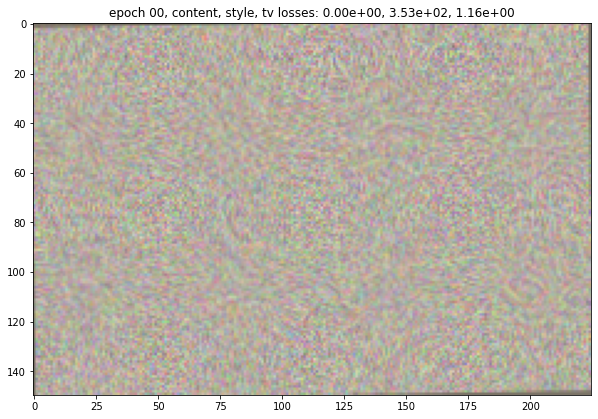

-0.995867402764918 0.597948847448379 0.4245614586761197 [0.03996816 0.14742273]
-0.967891415674216 0.3148820475263047 -0.07763714953163137 [-0.2830668  -0.50219861]
-0.31622979390538963 0.16311057545471566 -0.8987928535264383 [-0.15177147 -0.8211557 ]


KeyboardInterrupt: ignored

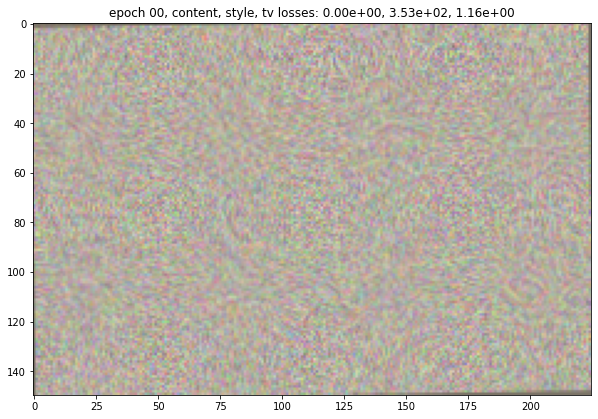

In [14]:
# optimizer = torch.optim.LBFGS(im_gen.parameters(),lr=2.5)
# train
fig, ax = plt.subplots(1,1,figsize=[10,10])

def closure_small():
    
    # transform = torchvision.transforms.RandomAffine(0, translate=(1./im_shape[1],1./im_shape[0]))
    im_generated = im_gen()
    # im_generated = im_gen()
    
    fm_gen_style = get_feature_maps(im_generated, style_layer_list, gen=True)
    fm_gen_content = get_feature_maps(im_generated, content_layer, gen=True) # having to go through the network again is a bit ugly
    gram_gen = get_gram(fm_gen_style)
    content_loss = get_content_loss(fm_content, fm_gen_content)
    style_loss = get_style_loss(gram_style,gram_gen)
    # tv_loss = get_TV_loss(im_generated)
    tv_loss = 0
    # for fm in fm_gen_content:
    #     tv_loss += get_TV_loss(fm)
    # for fm in fm_gen_style:
    #     tv_loss += get_TV_loss(fm)
    # tv_loss/=len(fm_gen_content)+len(fm_gen_style)

    tv_loss += get_TV_loss(im_generated)
    return content_loss, style_loss, tv_loss

def closure():
    optimizer.zero_grad()
    content_loss, style_loss, tv_loss = closure_small()
    loss = content_weight*content_loss + style_weight*style_loss + tv_weight*tv_loss
    # print(f"content, style, tv losses: {content_weight*content_loss:.2e}, {style_weight*style_loss:.2e}, {tv_weight*tv_loss:.2e}")
    loss.backward()
    return loss

last_loss = 1e10
jit_i, jit_j = 0, 0,
for i in range(10000):    
#     im_generated = im_gen()
    # implement jitter as a random walk
    # jit_max = 2
    # temp = np.random.standard_normal(2)
    # jit_i += temp[0]
    # jit_j += temp[1]
    # jit_i, jit_j = np.clip([jit_i, jit_j],-jit_max,jit_max).astype(int)
    # print(jit_i, jit_j)

    # Get a new set of feature maps with random affine transformation
    
    # with torch.no_grad():
    #     fm_style = get_feature_maps(im_style, style_layer_list)
    #     fm_content = get_feature_maps(im_content, content_layer)
    #     gram_style = get_gram(fm_style)
        
    # jit_i, jit_j = np.clip(np.round((np.random.standard_normal(2)*.5)*jit_max),-jit_max,jit_max).astype(int)
    im_gen.jitter()
    
    optimizer.step(closure)
    scheduler.step()
    # adjust weights
    if i%10==0:
        with torch.no_grad():
            content_loss, style_loss, tv_loss = closure_small()
            loss = content_weight*content_loss + style_weight*style_loss + tv_weight*tv_loss
            # if tv_weight*tv_loss>0.2*(style_weight*style_loss) or tv_weight*tv_loss>0.2*content_weight*content_loss:
            #     tv_weight *= 0.75
            imnew = postprocess(im_gen())
            plt.clf()
            plt.imshow(imnew)
            plt.title(f"epoch {i:02d}, content, style, tv losses: {content_weight*content_loss:.2e}, {style_weight*style_loss:.2e}, {tv_weight*tv_loss:.2e}")
            clear_output(wait = True)
            display(fig)

            


            # if loss<abs_loss_limit:
            #     clear_output(wait = True)
            #     print(f'success: absolute loss limit ({abs_loss_limit:.1e}) reached')
            #     break
            # if torch.abs(last_loss-loss)<rel_loss_limit:
            #     clear_output(wait = True)
            #     print(f'stopped because relative loss limit ({rel_loss_limit:.1e})  was reached')
            #     break
                
            last_loss = loss

In [ ]:
gram_style[0].shape

In [286]:
im_gen.transform.parameters

<bound method Module.parameters of RandomAffine(degrees=[0.0, 0.0], translate=(0.0044444444444444444, 0.006666666666666667))>